In [1]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
%matplotlib inline

# Основне завдання

## 1. Побудувати та проаналізувати часовий ряд для статистики захворювань на Covid в двох сусідніх країнах по вашому вибору (дані взяти в інтернеті).

### 1.1 Зчитування датасету про захворювання на Covid у світі у датафрейм

In [2]:
covid_df = pd.read_csv('../data/owid-covid-data.csv', index_col=['date'], parse_dates=['date'])
covid_df.head()

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-04,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-05,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-06,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-07,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


### 1.2 Заповнення нулями пропущених значень стовпця, що містить нові випадки захворювання, для Німеччини та Франції (2 обрані сусідні країни)

In [3]:
france_df = covid_df[covid_df['location'] == 'France']['new_cases'].fillna(0).astype(int)
france_df.head()

date
2020-01-03    0
2020-01-04    0
2020-01-05    0
2020-01-06    0
2020-01-07    0
Name: new_cases, dtype: int64

In [4]:
germany_df = covid_df[covid_df['location'] == 'Germany']['new_cases'].fillna(0).astype(int)
germany_df.head()

date
2020-01-03    0
2020-01-04    1
2020-01-05    0
2020-01-06    0
2020-01-07    0
Name: new_cases, dtype: int64

### 1.3 Графічна візуалізація часових послідовностей для цих двох країн (графіки захворювань)

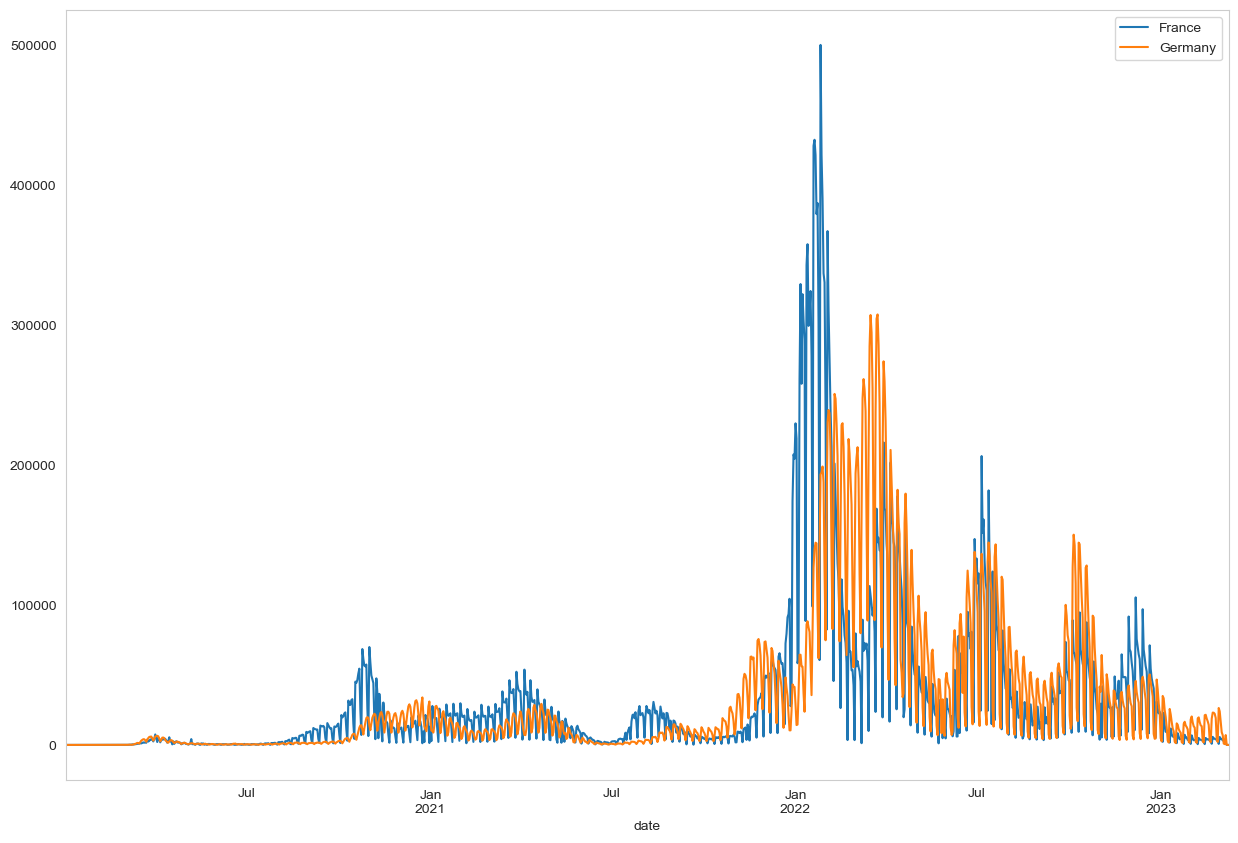

In [5]:
plt.figure(figsize=(15, 10))
for df in [france_df, germany_df]:
    df.plot()
plt.grid()
plt.legend(['France', 'Germany']);

### 1.4 Використання ковзуючого середнього для згладжування часових послідовностей з різними розмірами вікон для Франції та Німеччини

In [6]:
def plot_moving_average(series, country):
    fig, ax = plt.subplots(4, figsize=(30, 20))
    window_sizes = [5, 10, 20, 40]
    for i, size in enumerate(window_sizes):
        rolling_mean = series.rolling(window=size).mean()
        ax[i].plot(series, label='Original')
        ax[i].plot(rolling_mean, label='Rolling Mean')
        ax[i].legend(loc='best')
        ax[i].set_title(f'Rolling Mean {country}\nwindow size = {window_sizes[i]}')

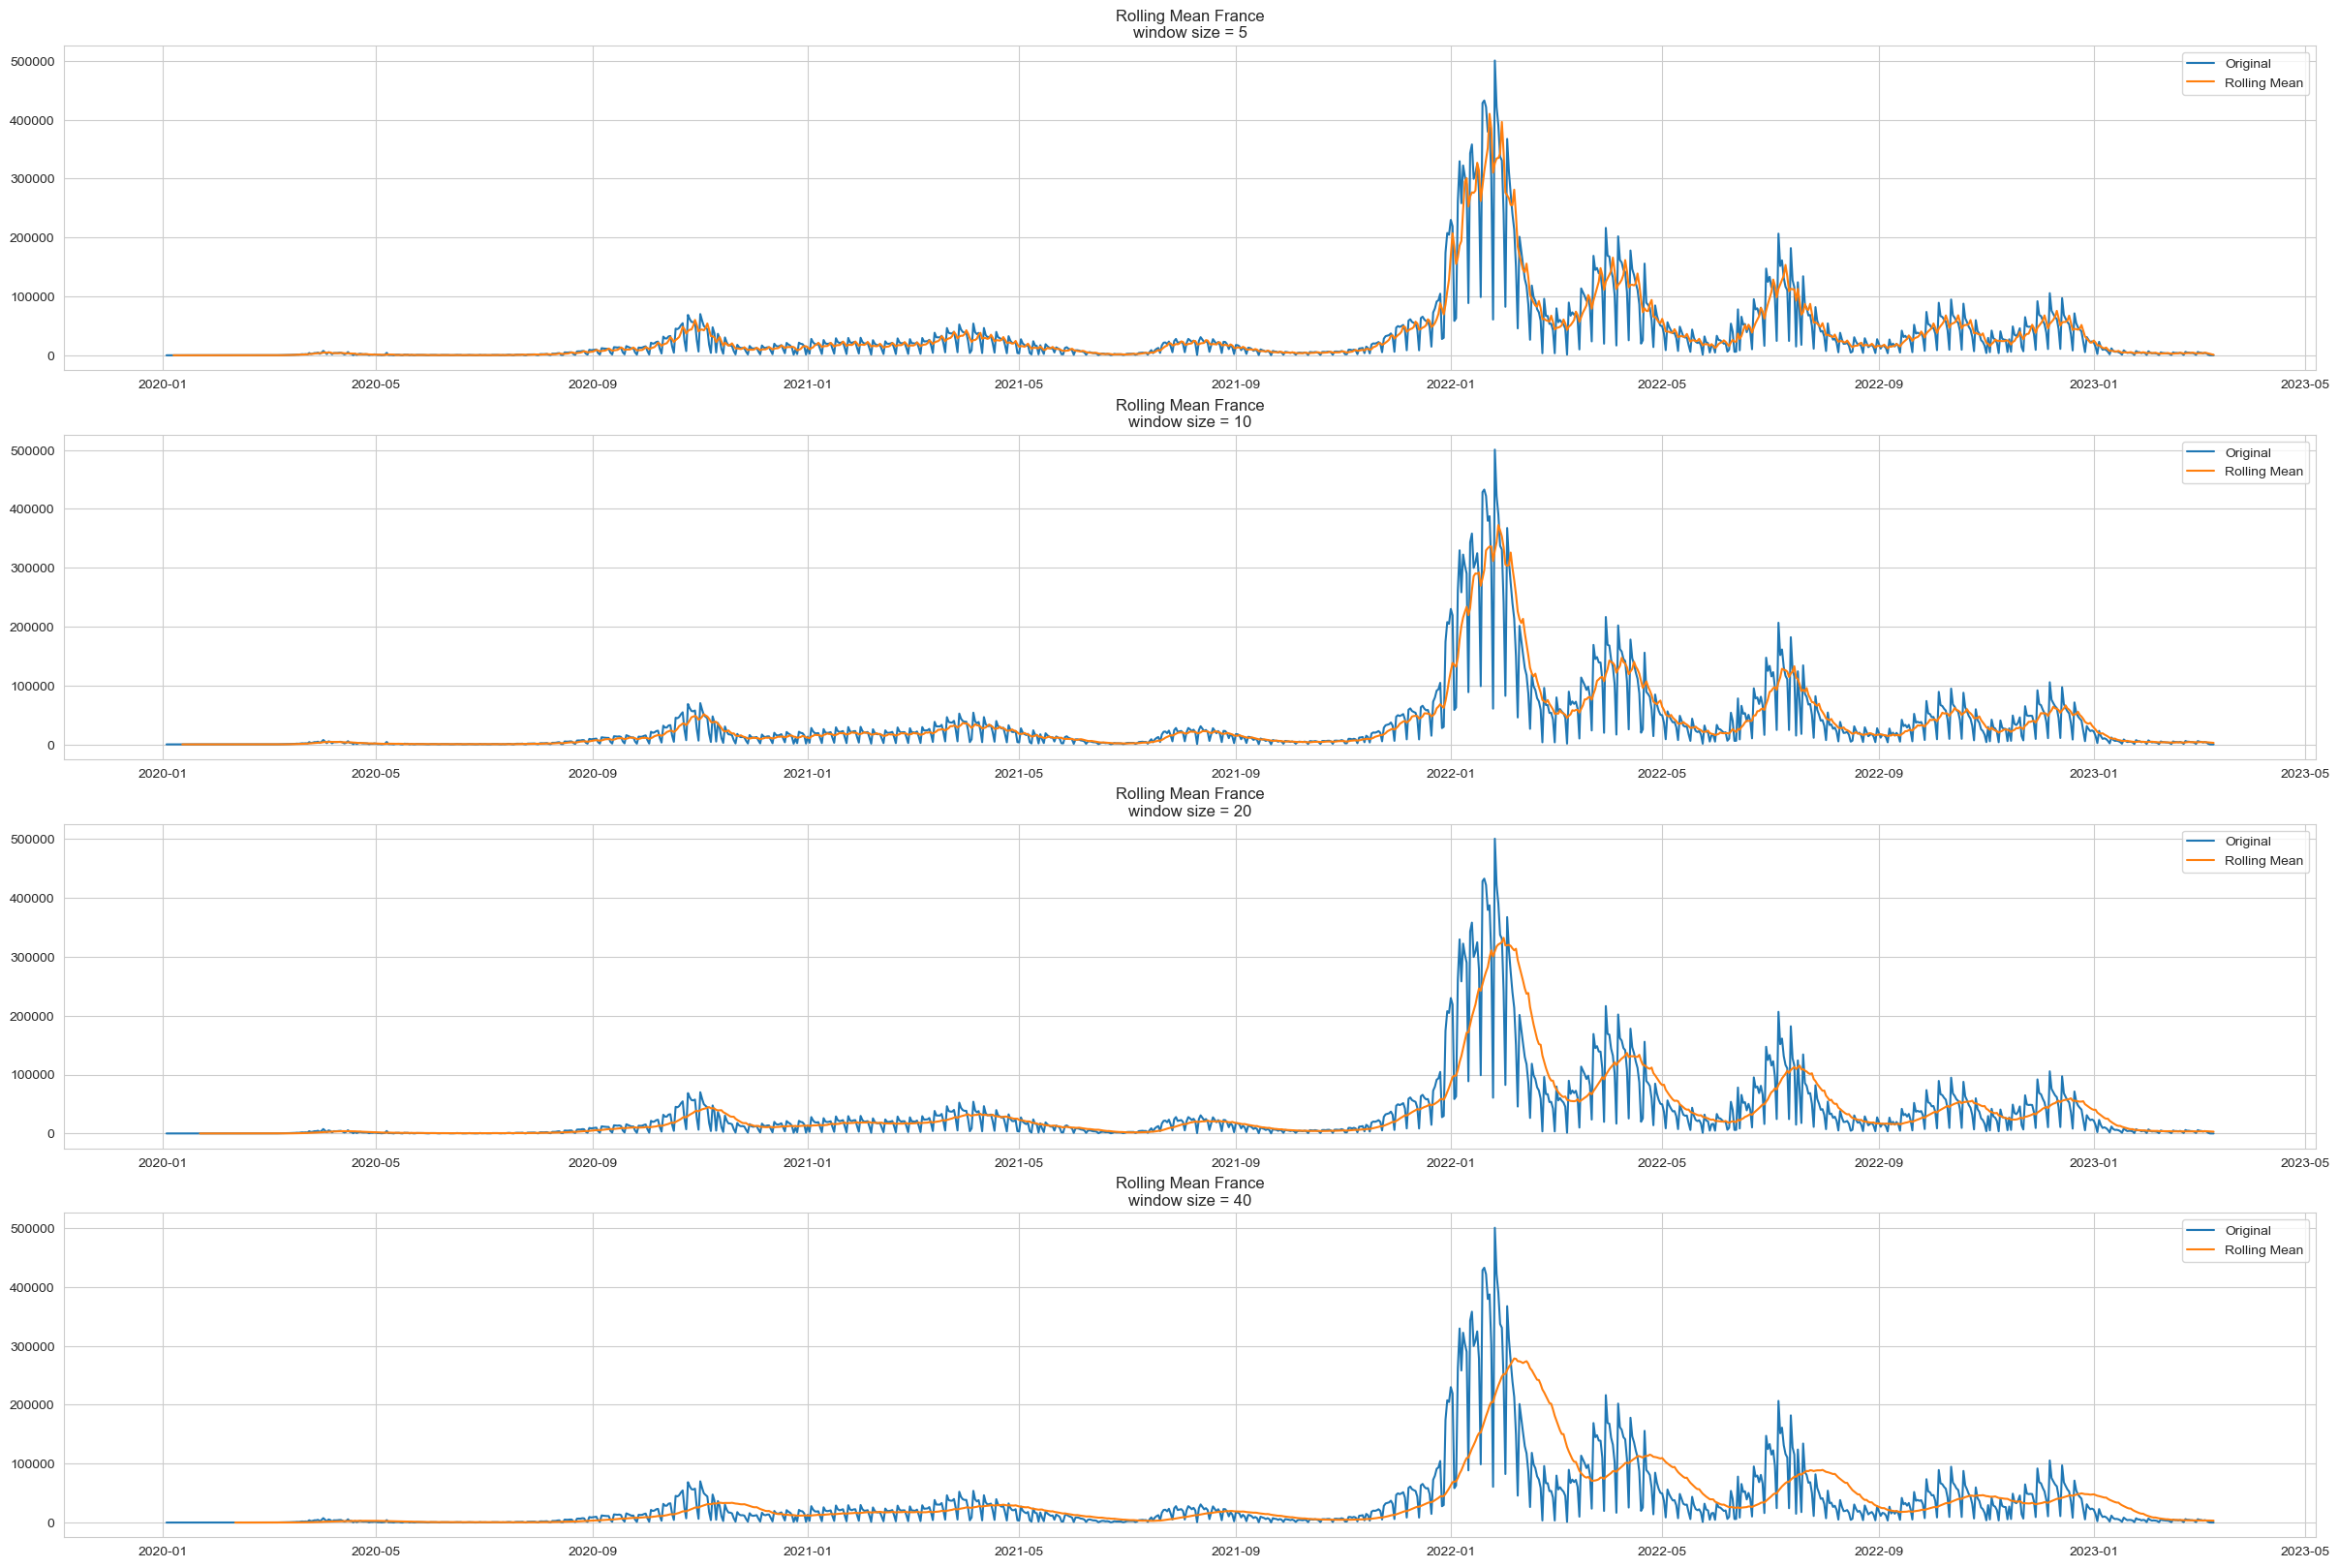

In [7]:
plot_moving_average(france_df, 'France')

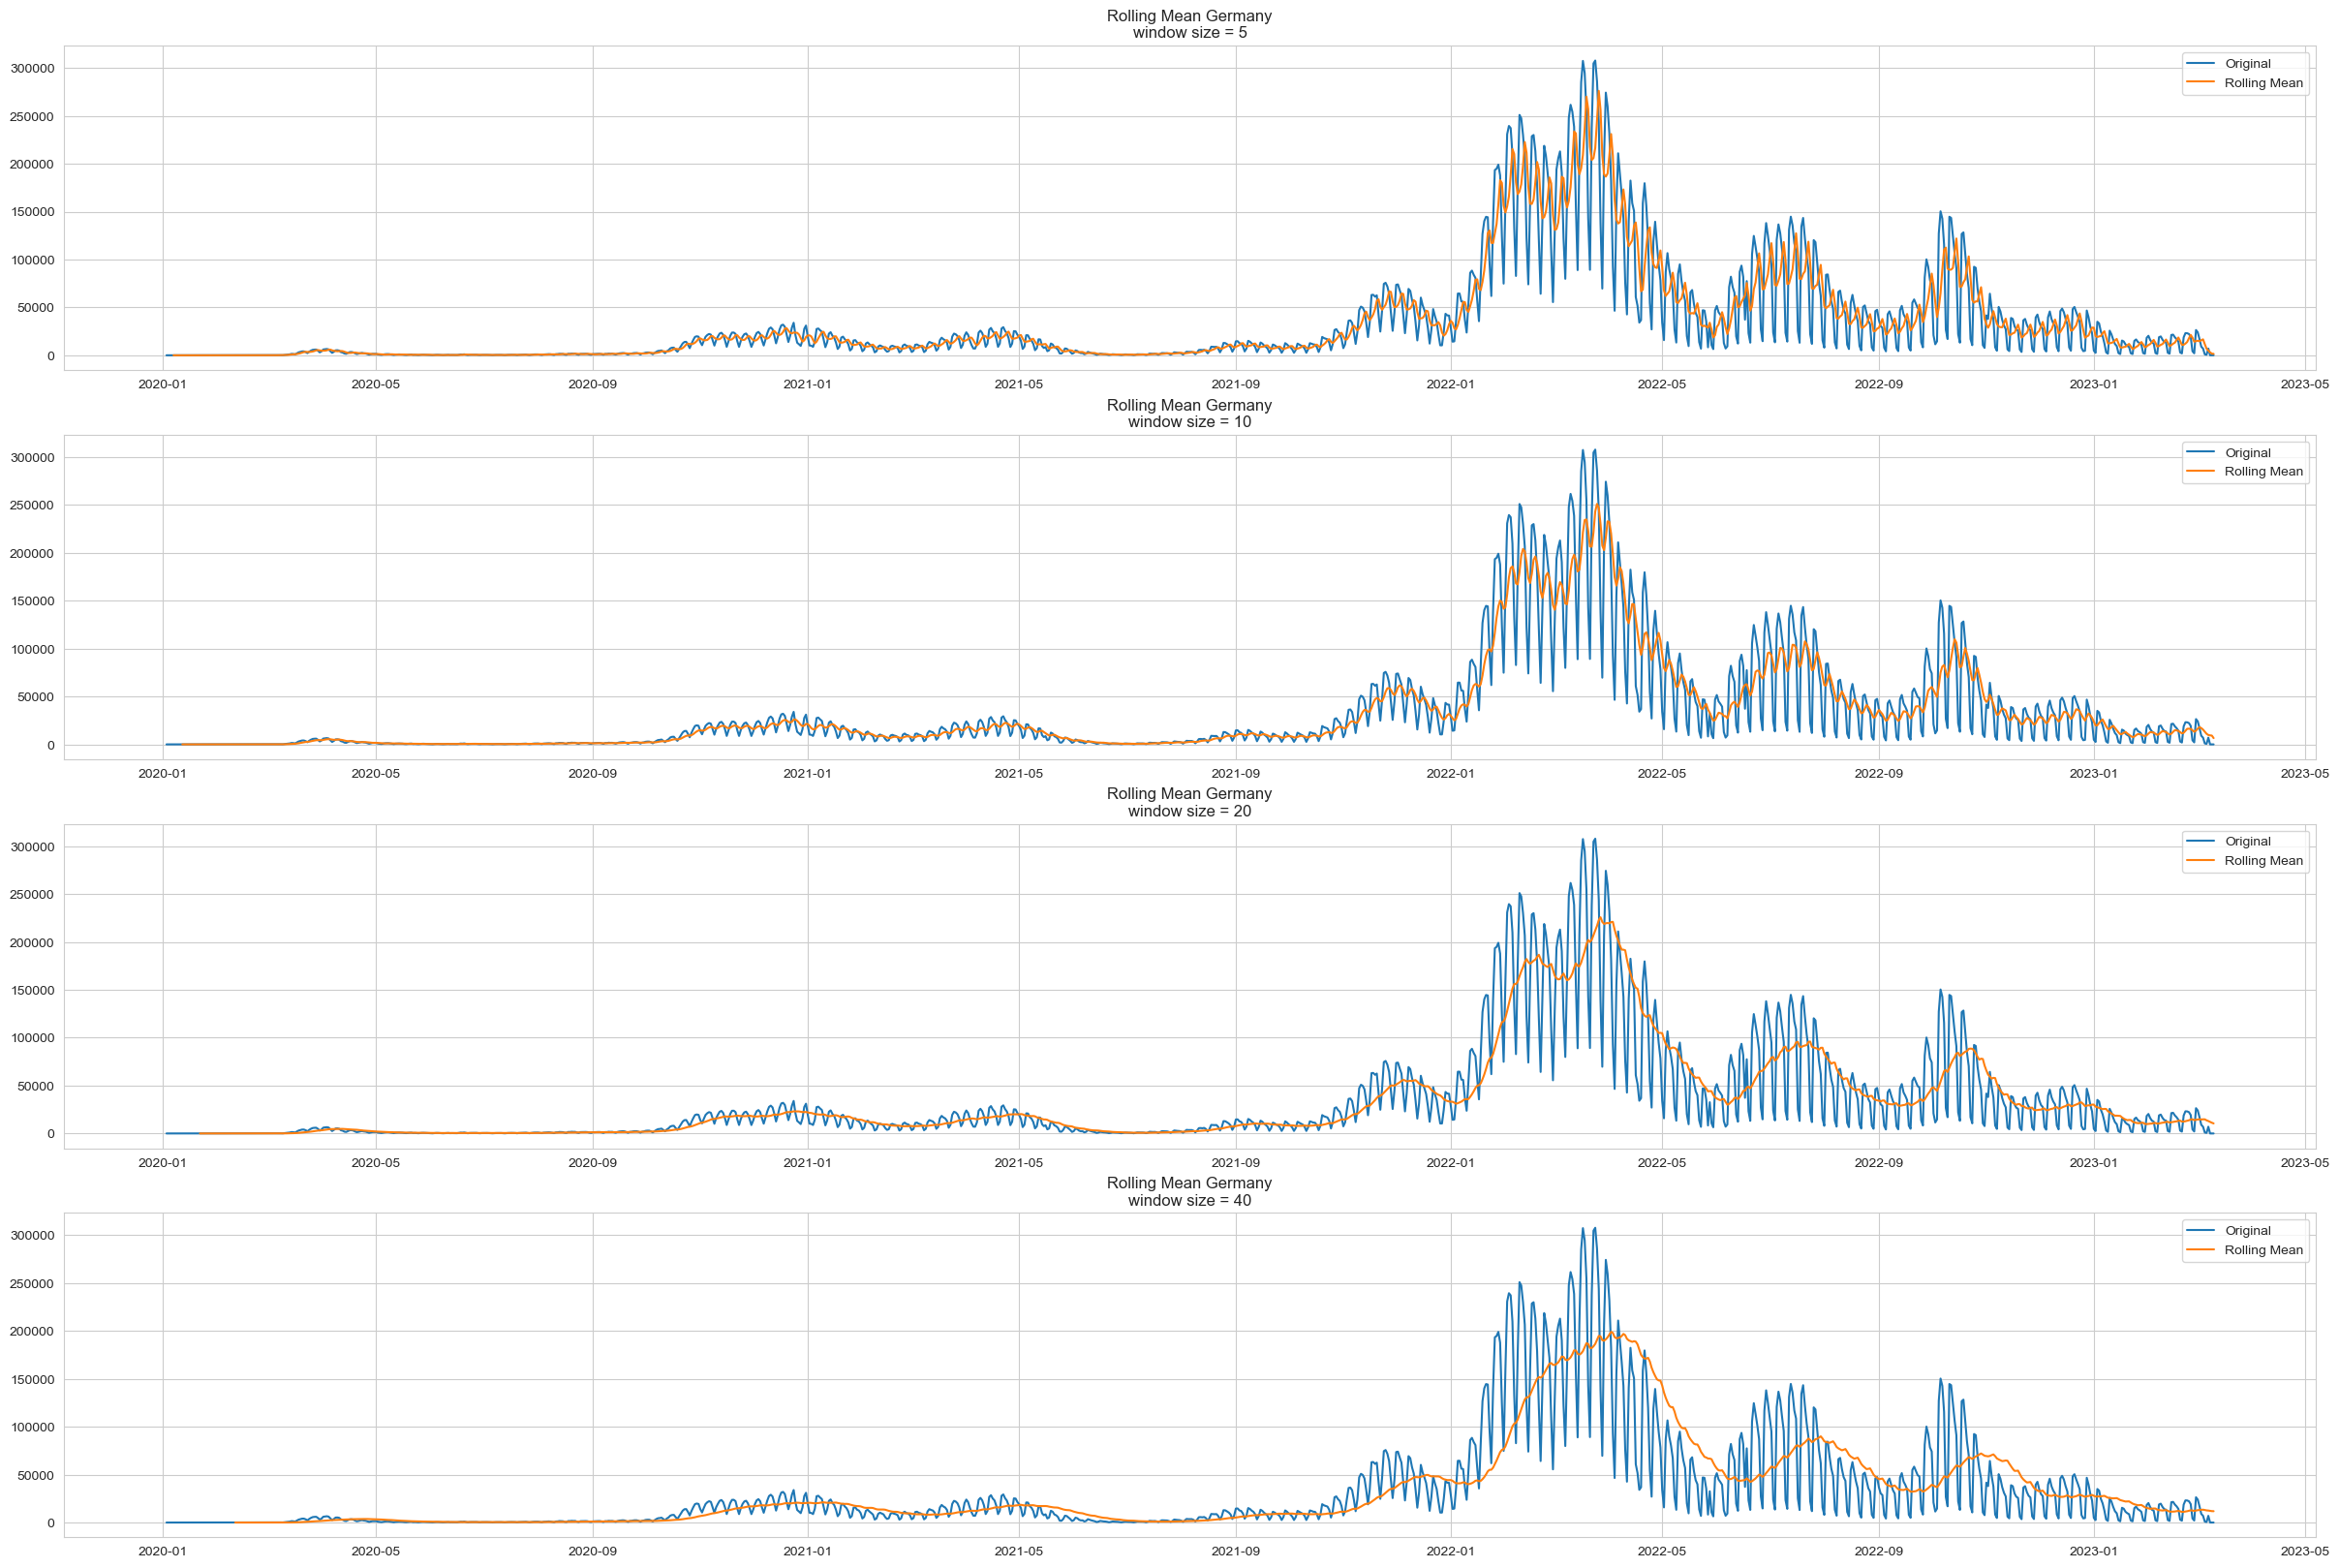

In [8]:
plot_moving_average(germany_df, 'Germany')

### Можна побачити, що оптимальним розміром вікна є 10.

### 1.5 Декомпозиція часових послідовностей для цих двох країн на компоненти (тренд, сезонна складова та нерегулярний компонент)

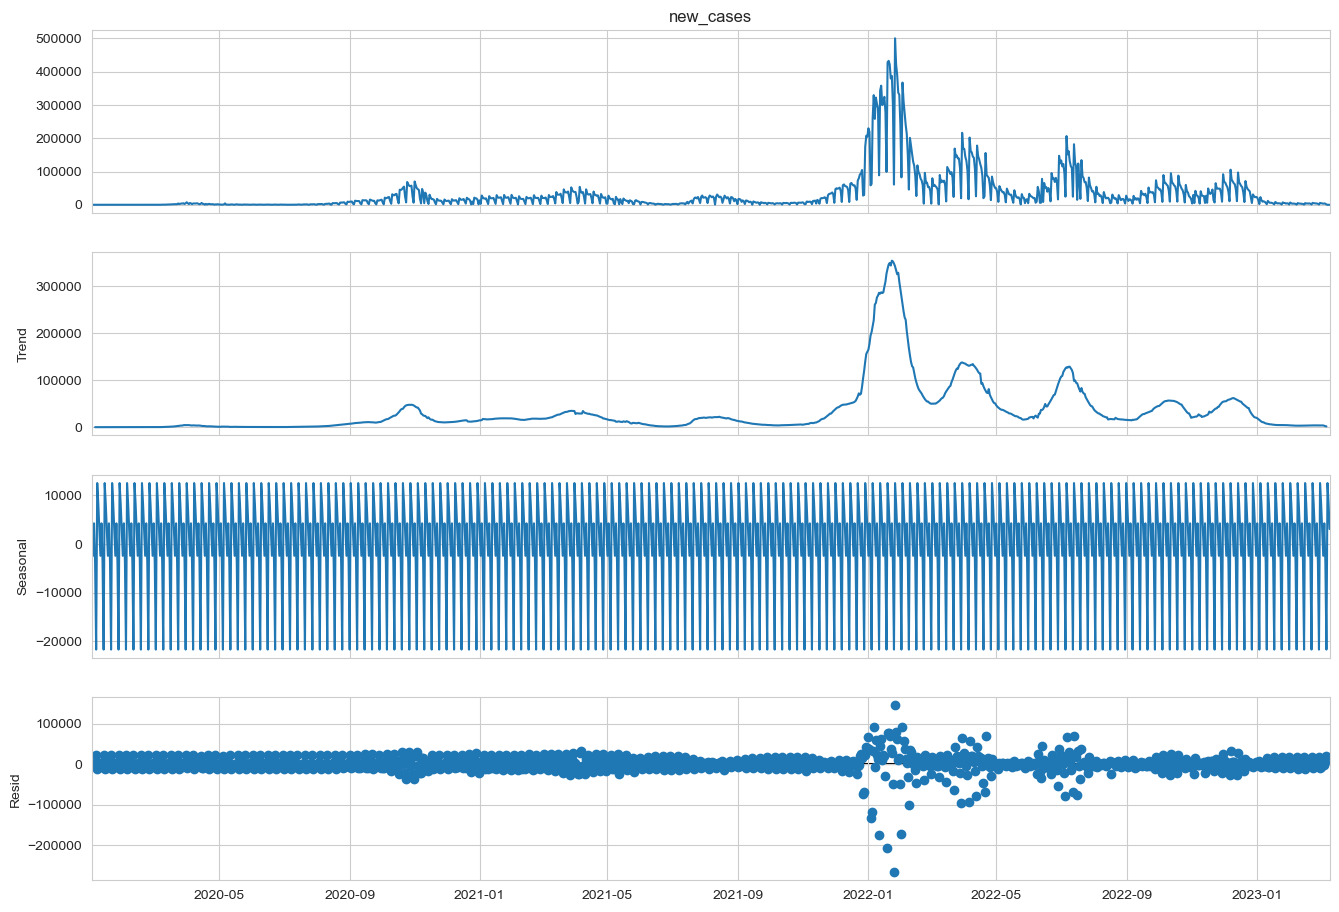

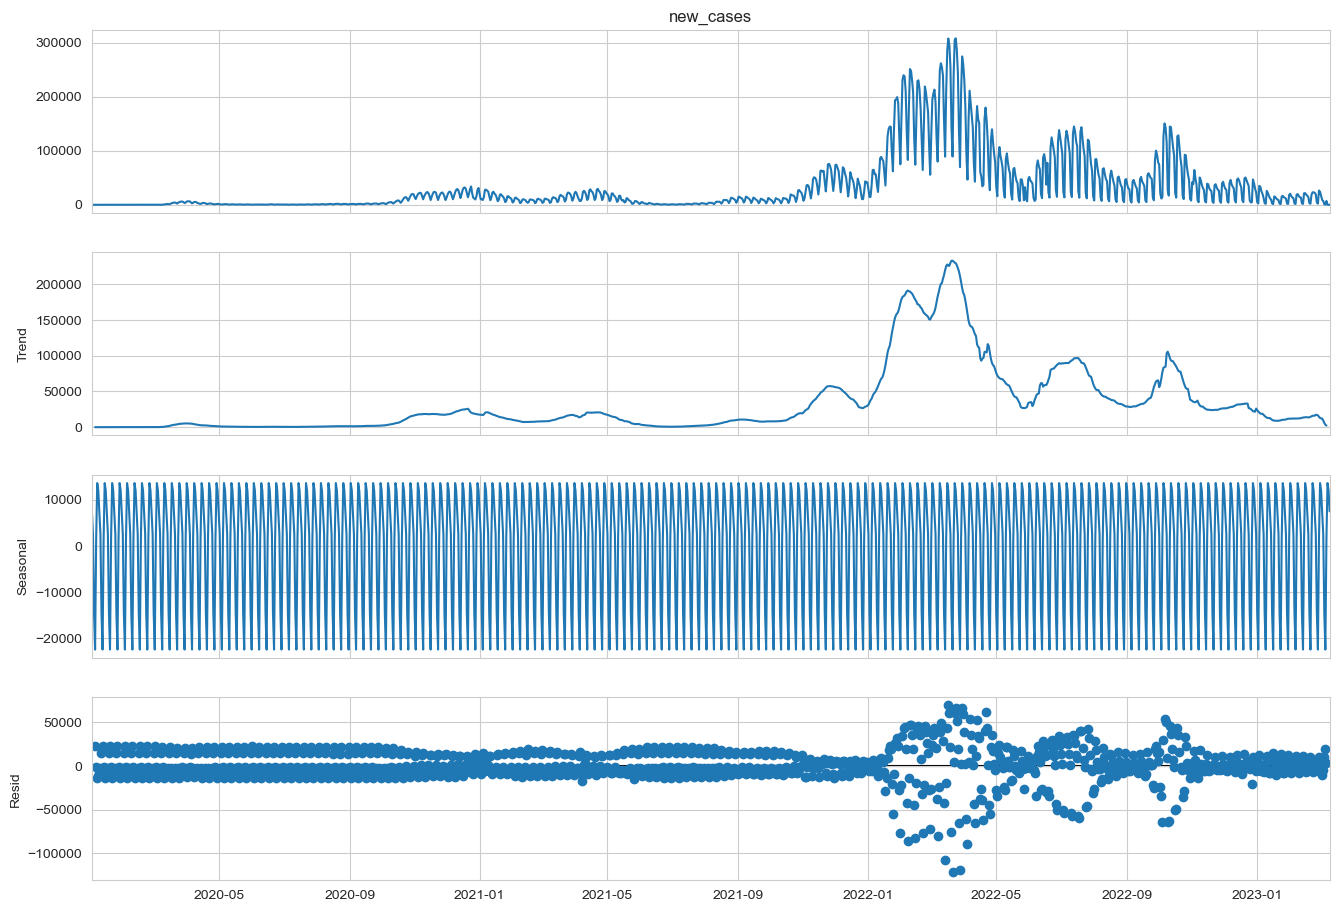

In [9]:
df_list = [france_df, germany_df]
for df in df_list:
    seasonal_decompose(df).plot().set_size_inches(15, 10)

### З отриманих візуалізацій видно, що відсутній чітко виражений тренд та сезонність.

### 1.6 Візуалізація графіків автокореляції та часткової автокореляції для Франції та Німеччини

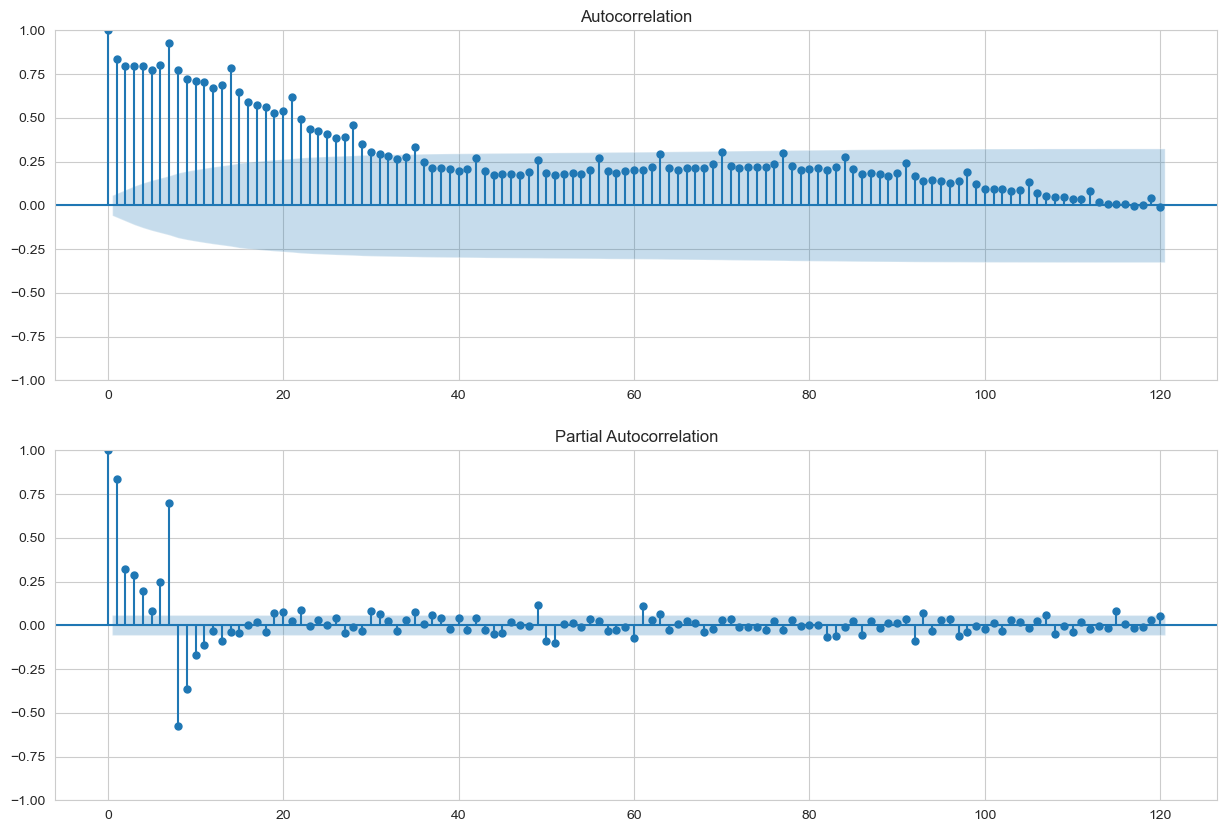

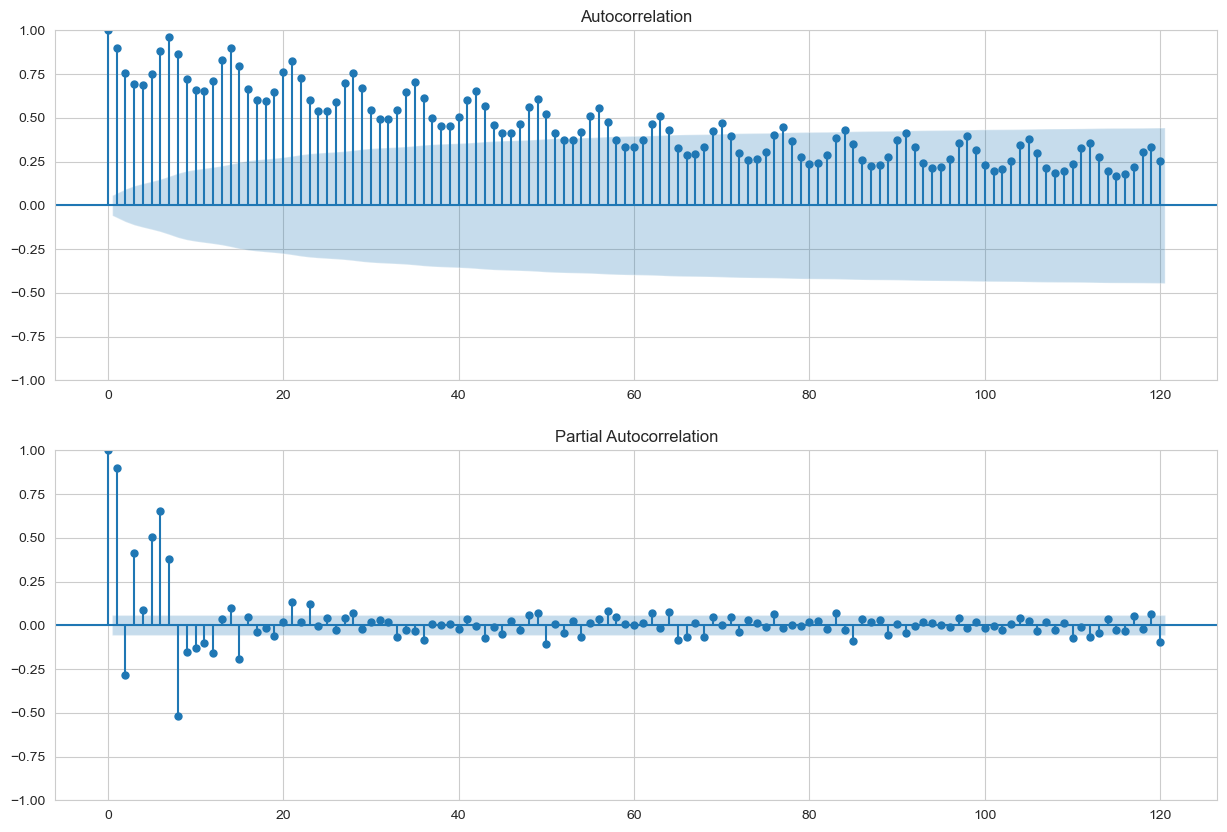

In [10]:
for df in df_list:
    fig, ax = plt.subplots(2, figsize=(15, 10))
    ax[0] = plot_acf(df, ax=ax[0], lags=120)
    ax[1] = plot_pacf(df, ax=ax[1], lags=120, method='ywm')

### 1.7 Тест Дікі-Фуллера з метою перевірки обох часових послідовностей на стаціонарність

In [11]:
def dickey_fuller_test(series):
    test = adfuller(series, autolag='AIC')
    print('adf: ', test[0])
    print('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0] > test[4]['5%']:
        print('Навні одиничні корені, ряд не стаціонарний.')
    else:
        print('Одиничні корені відсутні, ряд є стаціонарним.')


countries = ['France', 'Germany']
for df, country in zip(df_list, countries):
    print(country)
    dickey_fuller_test(df)

France
adf:  -3.790464638010212
p-value:  0.003006394848397305
Critical values:  {'1%': -3.4360941478268767, '5%': -2.864076408006588, '10%': -2.568120448620112}
Одиничні корені відсутні, ряд є стаціонарним.
Germany
adf:  -2.242566516853596
p-value:  0.1911604197651745
Critical values:  {'1%': -3.4360991979671205, '5%': -2.864078635828568, '10%': -2.568121635118498}
Навні одиничні корені, ряд не стаціонарний.


### На основі цього тесту часовий ряд для Німеччини не є стаціонарним, тому з використанням методу диференціювання шляхом взяття перших різниць можна отримати стаціонарний ряд.

In [12]:
dickey_fuller_test(germany_df.diff().dropna())

adf:  -7.651743160459984
p-value:  1.781786873326879e-11
Critical values:  {'1%': -3.4361093249345402, '5%': -2.8640831032339706, '10%': -2.5681240143809787}
Одиничні корені відсутні, ряд є стаціонарним.


## 2. Побудувати та проаналізувати часовий ряд для курсу гривня/долар або гривня/євро за останні 3 роки (дані взяти в інтернеті)

### 2.1 Зчитування датасету про курс гривні до доллара у датафрейм та обрання записів за 3 останні роки

In [13]:
currencies_df = pd.read_csv('../data/usd_uah.csv', index_col='Date', parse_dates=['Date'])[::-1].loc[:, 'Price']
currencies_df = currencies_df.loc['2021':]
currencies_df.head()

Date
2021-01-01    28.4753
2021-01-04    28.4290
2021-01-05    28.4200
2021-01-06    28.2432
2021-01-11    28.1190
Name: Price, dtype: float64

### 2.2 Графік зміни курсу

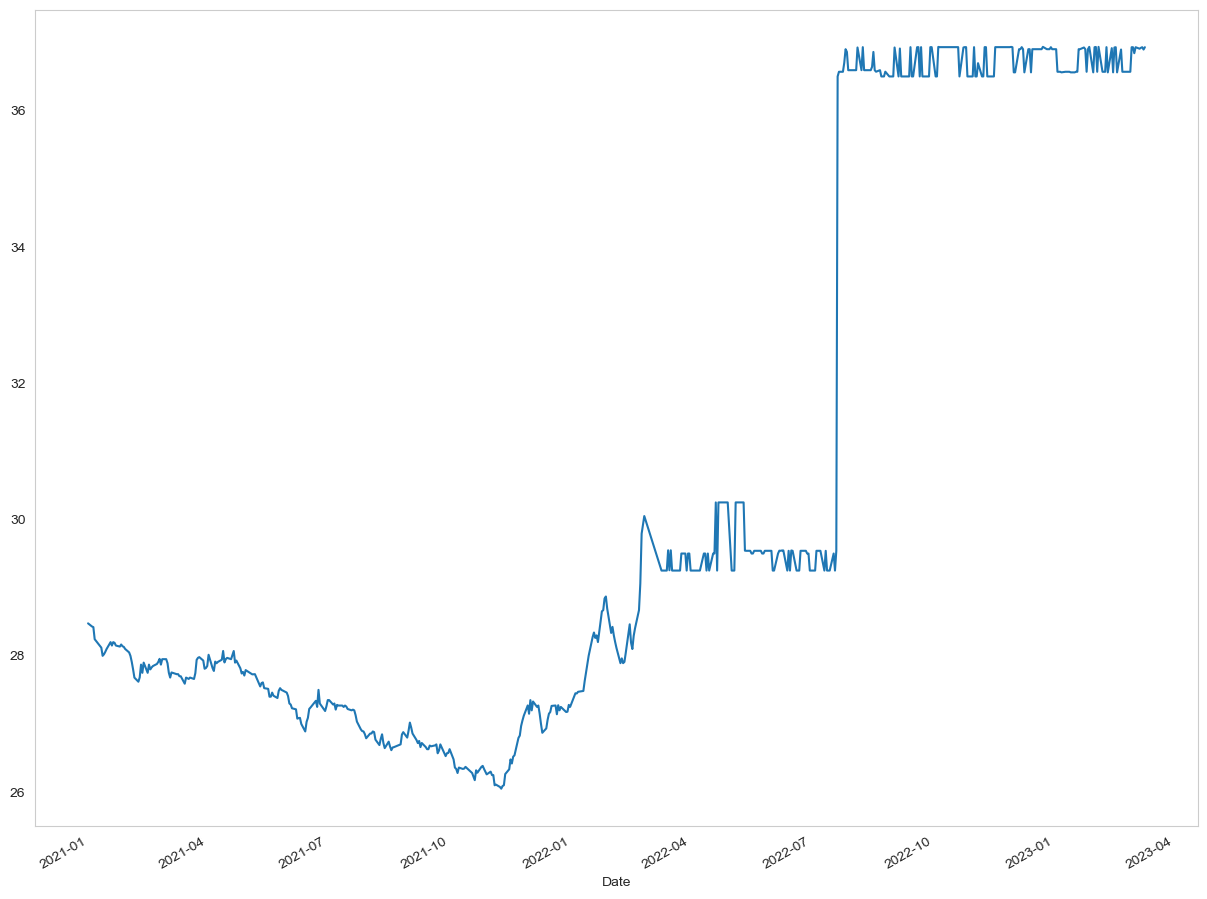

In [14]:
plt.figure(figsize=(15, 12))
currencies_df.plot()
plt.grid()

### 2.3 Використання ковзуючого середнього для згладжування часового ряду з розміром вікна 10

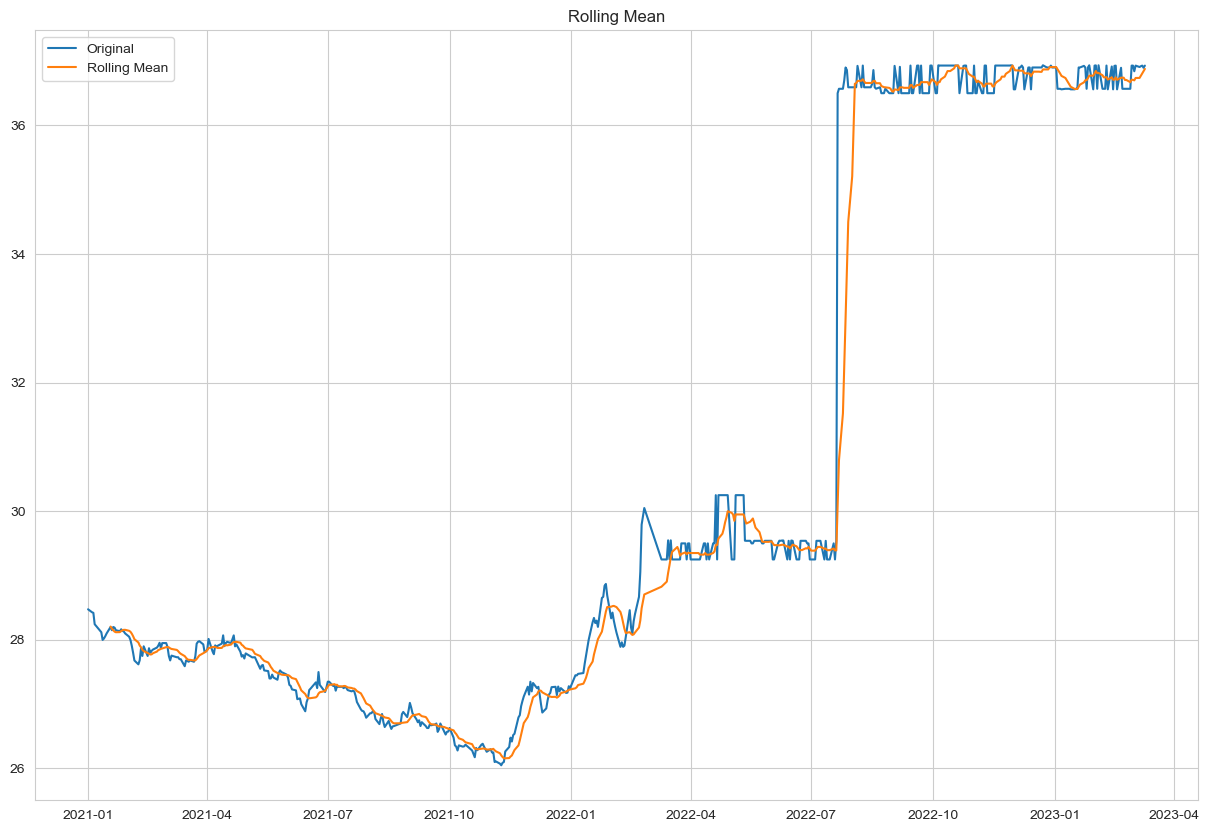

In [15]:
plt.figure(figsize=(15, 10))
rolling_mean = currencies_df.rolling(window=10).mean()
plt.plot(currencies_df, label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean');

### 2.4 Декомпозиція часової послідовності на компоненти

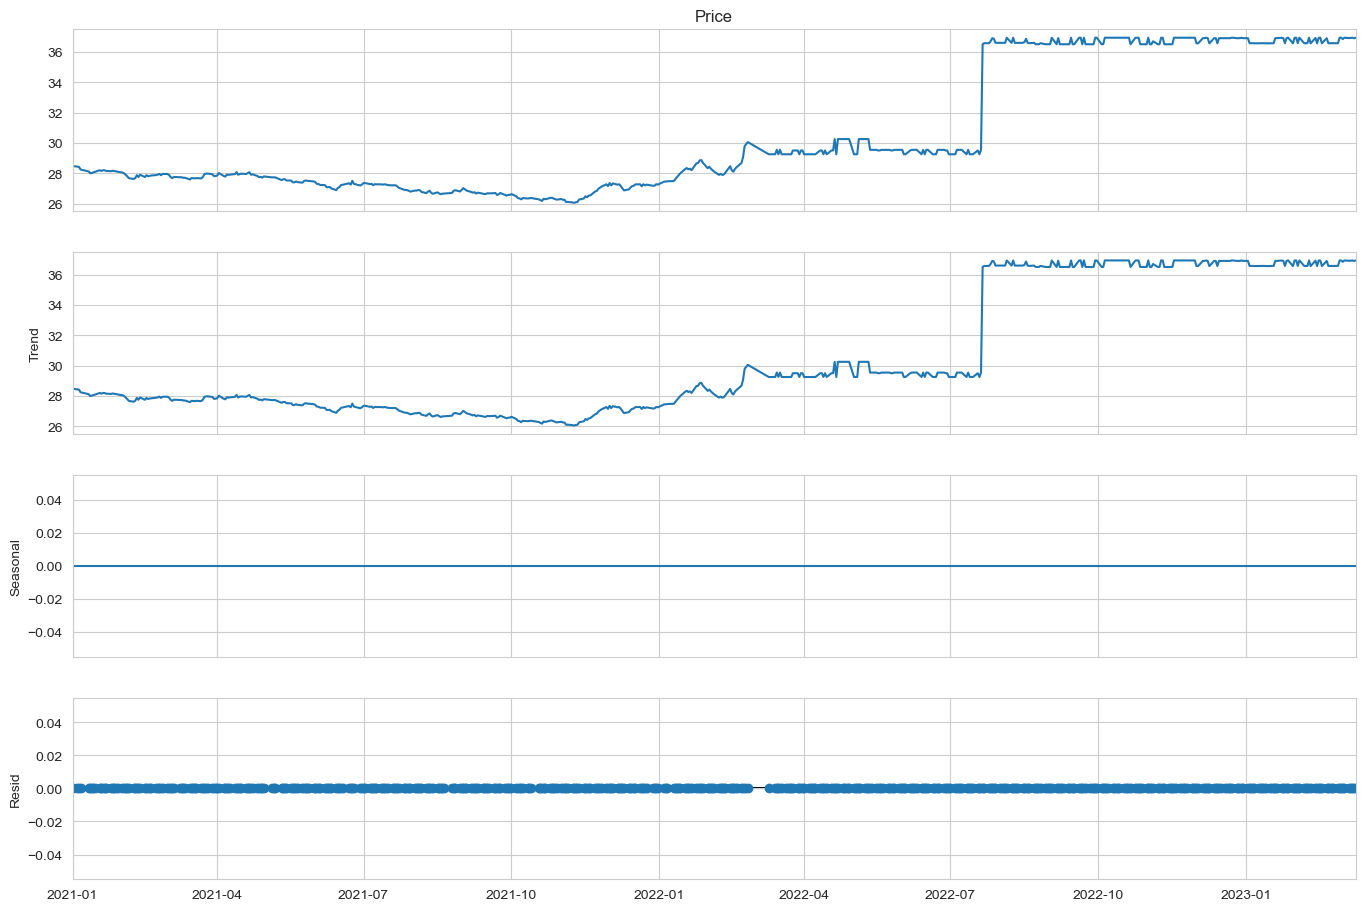

In [16]:
price_decomposition = seasonal_decompose(currencies_df, period=1)
price_decomposition.plot().set_size_inches(15, 10)

### Можна побачити, що як тренд і сезонність як такі відсутні.

### 2.5 Графік корялеції та автокореляції

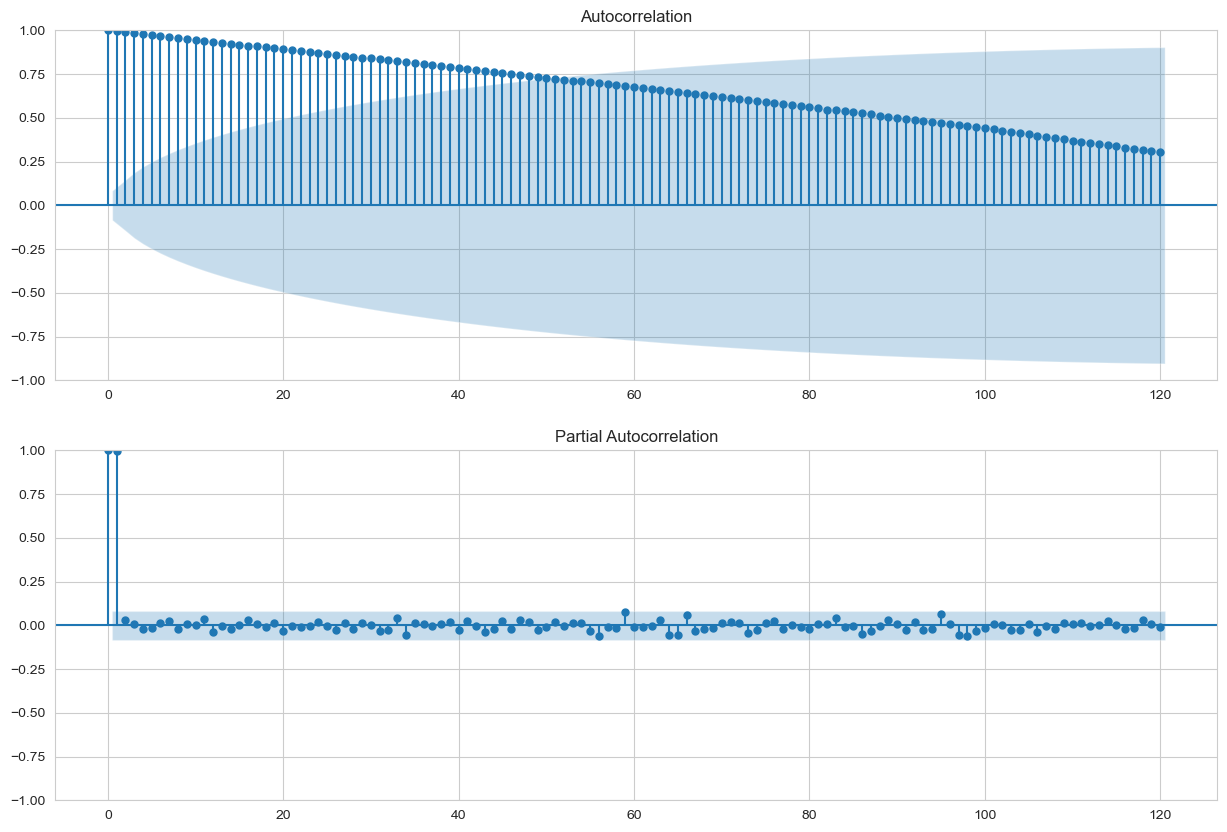

In [17]:
fig, ax = plt.subplots(2, figsize=(15, 10))
ax[0] = plot_acf(currencies_df, ax=ax[0], lags=120)
ax[1] = plot_pacf(currencies_df, ax=ax[1], lags=120, method='ywm')

### 2.6 Тест Дікі-Фуллера з метою перевірки часового ряду на стаціонарність

In [18]:
dickey_fuller_test(currencies_df)

adf:  -0.46708706421402
p-value:  0.898280793527414
Critical values:  {'1%': -3.442405720052601, '5%': -2.866857804790472, '10%': -2.5696022094099824}
Навні одиничні корені, ряд не стаціонарний.


### Оскільки ряд не є стаціонарним, а значущий лаг тільки 1, то шляхом взяття перших різниць можна привести ряд до стаціонарного.

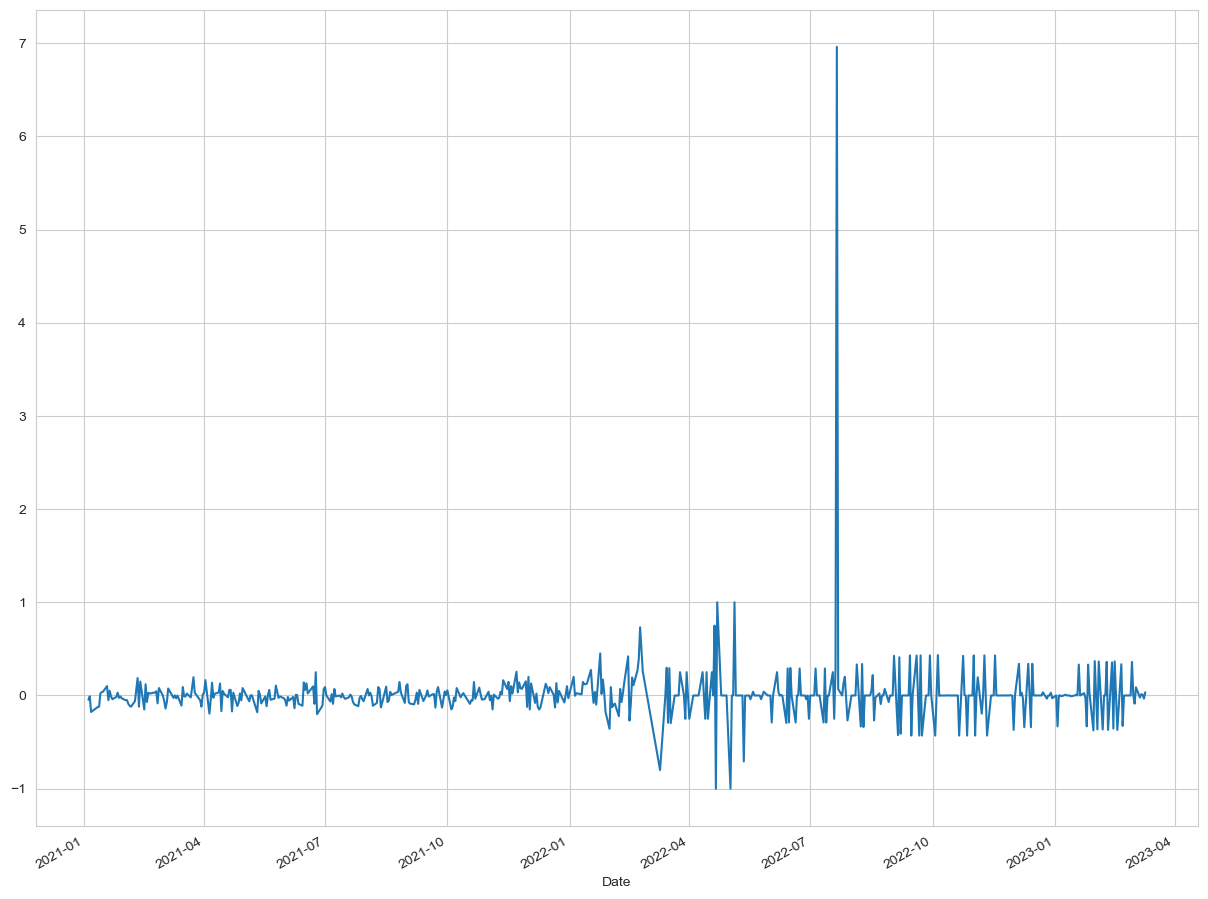

In [19]:
currencies_price_df_diff = currencies_df.diff(periods=1).dropna()
plt.figure(figsize=(15, 12))
currencies_price_df_diff.plot();

In [20]:
dickey_fuller_test(currencies_price_df_diff)

adf:  -24.504383918089296
p-value:  0.0
Critical values:  {'1%': -3.4424279871882573, '5%': -2.8668676073304407, '10%': -2.569607433093642}
Одиничні корені відсутні, ряд є стаціонарним.


### 2.7 Графік корялеції та автокореляції для часового ряду після взяття перших різниць

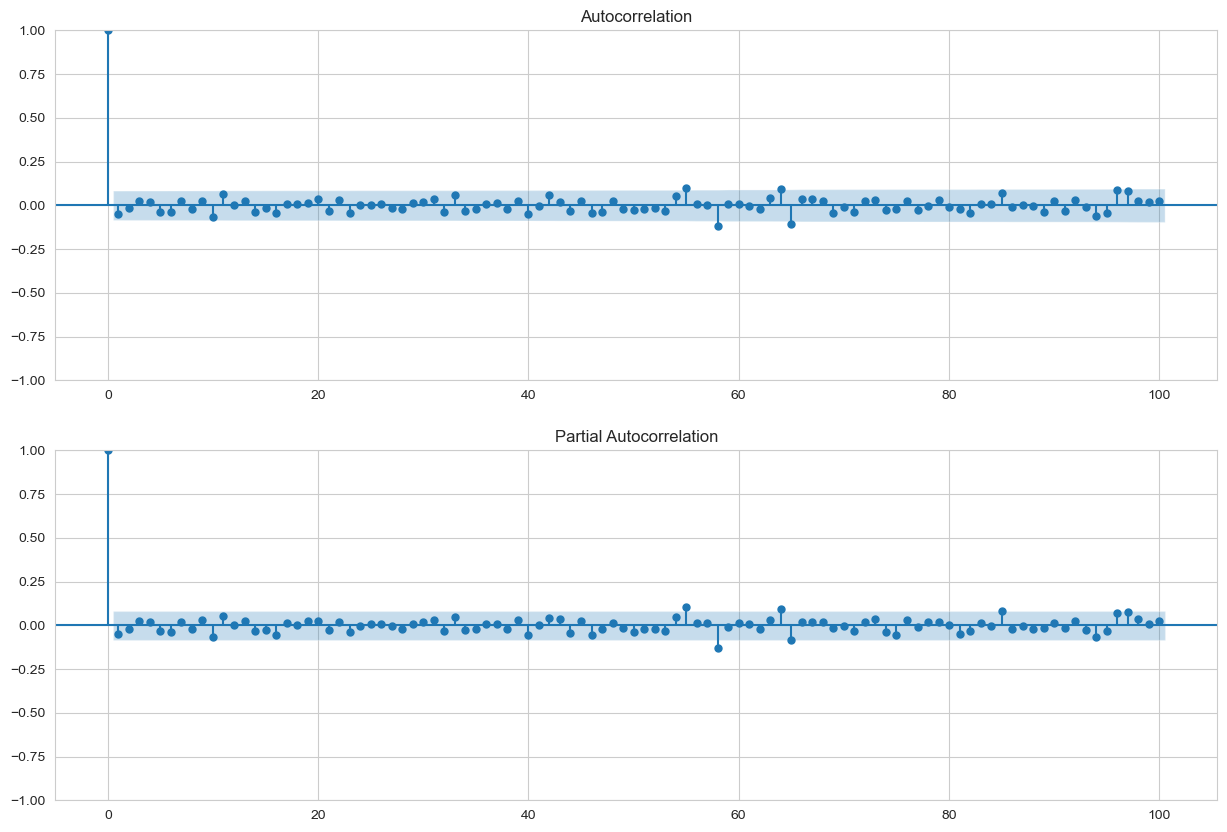

In [21]:
fig, ax = plt.subplots(2, figsize=(15, 10))
ax[0] = plot_acf(currencies_price_df_diff, ax=ax[0], lags=100)
ax[1] = plot_pacf(currencies_price_df_diff, ax=ax[1], lags=100, method='ywm')

### 2.8 Навчання моделі ARIMA з параметрами p = 1  та q = 1

In [22]:
currencies_df.index = pd.DatetimeIndex(currencies_df.index).to_period('D')
model = ARIMA(currencies_df, order=(1, 1, 1)).fit()

In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  546
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -203.742
Date:                Tue, 05 Sep 2023   AIC                            413.484
Time:                        22:51:48   BIC                            426.386
Sample:                    01-01-2021   HQIC                           418.528
                         - 03-10-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1099      1.733      0.063      0.949      -3.286       3.506
ma.L1         -0.1602      1.733     -0.092      0.926      -3.556       3.236
sigma2         0.1237      0.001    139.954      0.000       0.122       0.125
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1798520.75
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              48.07   Skew:                            14.23
Prob(H) (two-sided):                  0.00   Kurtosis:                       282.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 2.9 Візуалізація прогнозу та істинних значень

/Users/kyryl/miniforge3/envs/LabsDataAnalysis/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['plot_insample']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


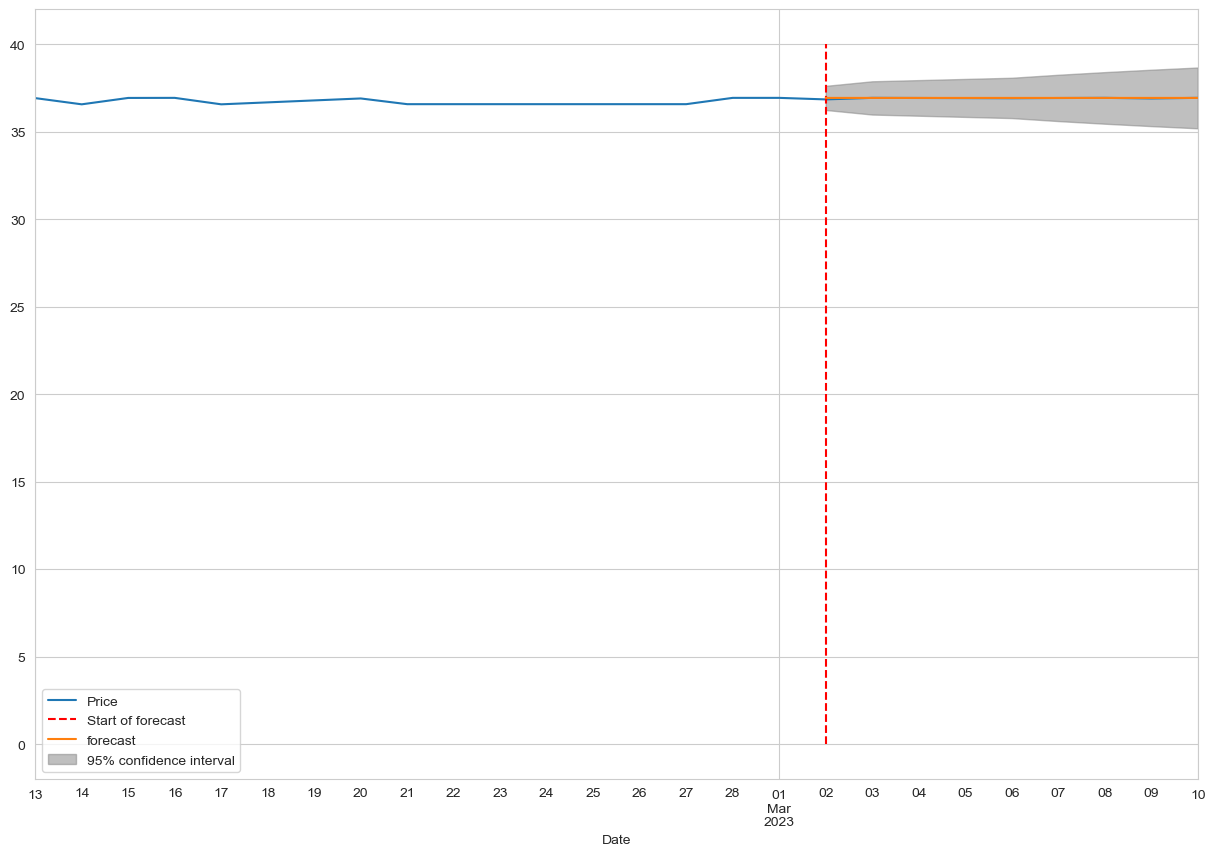

In [24]:
fig, ax = plt.subplots(figsize=(15, 10))
currencies_df[-20:].plot(ax=ax)
ax.vlines(currencies_df.index[-7], 0, 40, linestyle='--', color='r', label='Start of forecast')
ax = plot_predict(model, currencies_df.index[-7], currencies_df.index[-1], dynamic=True, plot_insample=False, ax=ax)

### Отримана модель досить непогано прогнозує курс (про це свідчать як метрики, так і візуалізація), проте лише на корткостроковий термін.

# Додаткове завдання

## 1 Зчитування датасету про погоду в Сіетлі за 1948-2017 роки

In [25]:
weather_df = pd.read_csv('../data/seattleWeather_1948-2017.csv', index_col='DATE', parse_dates=['DATE'])
weather_df.head()

,PRCP,TMAX,TMIN,RAIN
DATE,,,,
1948-01-01,0.47,51,42,True
1948-01-02,0.59,45,36,True
1948-01-03,0.42,45,35,True
1948-01-04,0.31,45,34,True
1948-01-05,0.17,45,32,True


## 2. Переведення температури в градуси Цельсію

In [26]:
weather_df.loc[:, 'TMAX': 'TMIN'] = (weather_df.loc[:, 'TMAX': 'TMIN'] - 32) * 5 / 9
weather_df.head()

,PRCP,TMAX,TMIN,RAIN
DATE,,,,
1948-01-01,0.47,10.555556,5.555556,True
1948-01-02,0.59,7.222222,2.222222,True
1948-01-03,0.42,7.222222,1.666667,True
1948-01-04,0.31,7.222222,1.111111,True
1948-01-05,0.17,7.222222,0.000000,True


## 3. Визначення кореляції між температурою та опадами шляхом побудови матриці кореляцій

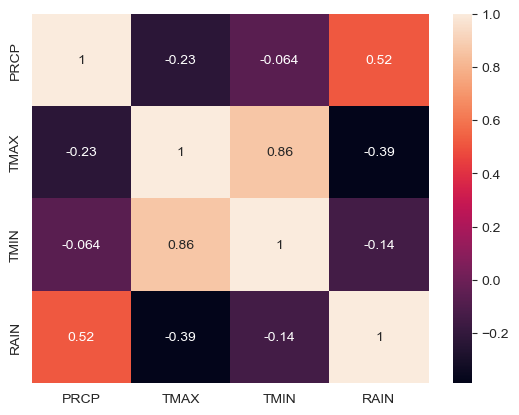

In [27]:
sns.heatmap(weather_df.corr(), annot=True);

### Можна побачити, що кореляція між температурою та опадами відсутня.

## 4. Скласти прогноз опадів на 2018 рік, оцінити точність прогнозу

### 4.1 Візуалізація зміни температур та кількості опадів та мінімальних й максимальних температур останніх 1000 днів

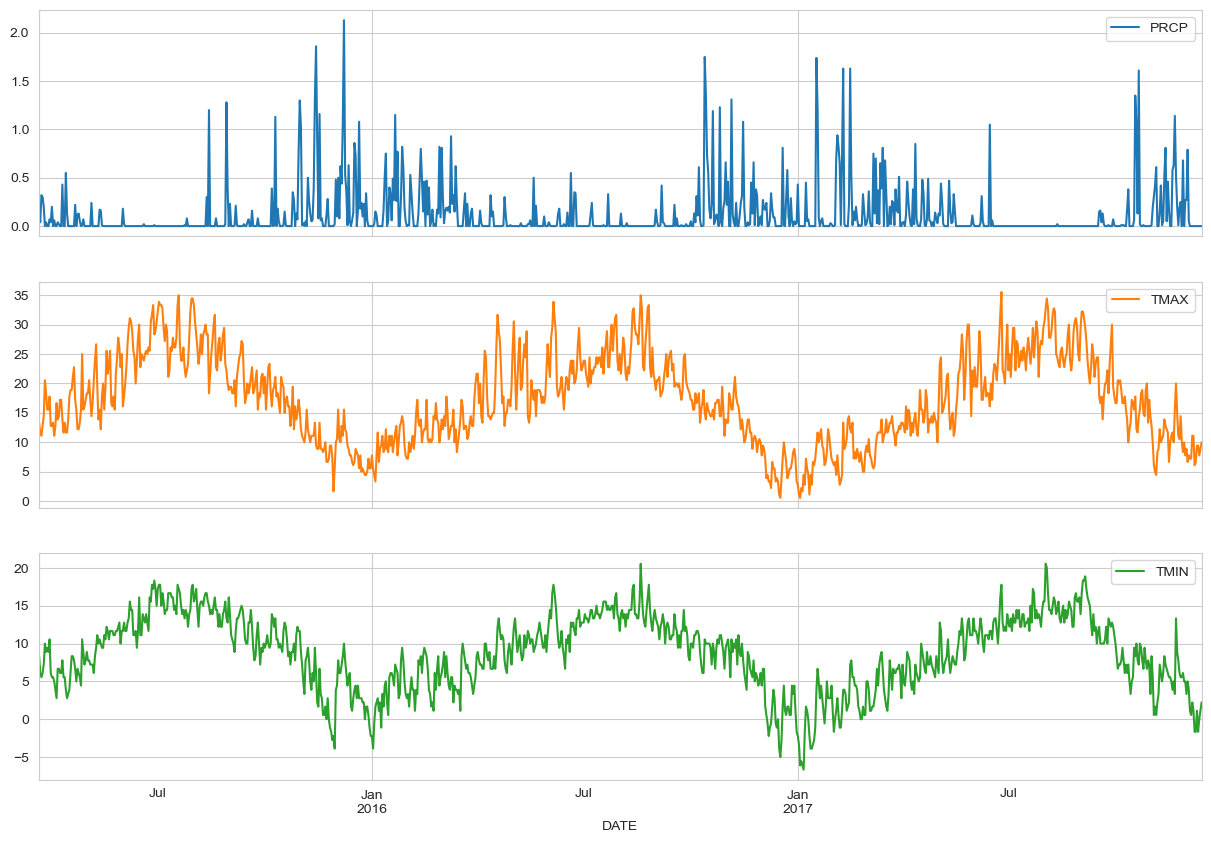

In [28]:
weather_df[-1000:].plot(subplots=True, figsize=(15, 10));

### Можна побачити, що присутня чітко виражена сезонність.

### 4.2 Масштабування часового ряду до тижнів шляхом обчислення середньої кількості опадів для кожного дня тижня

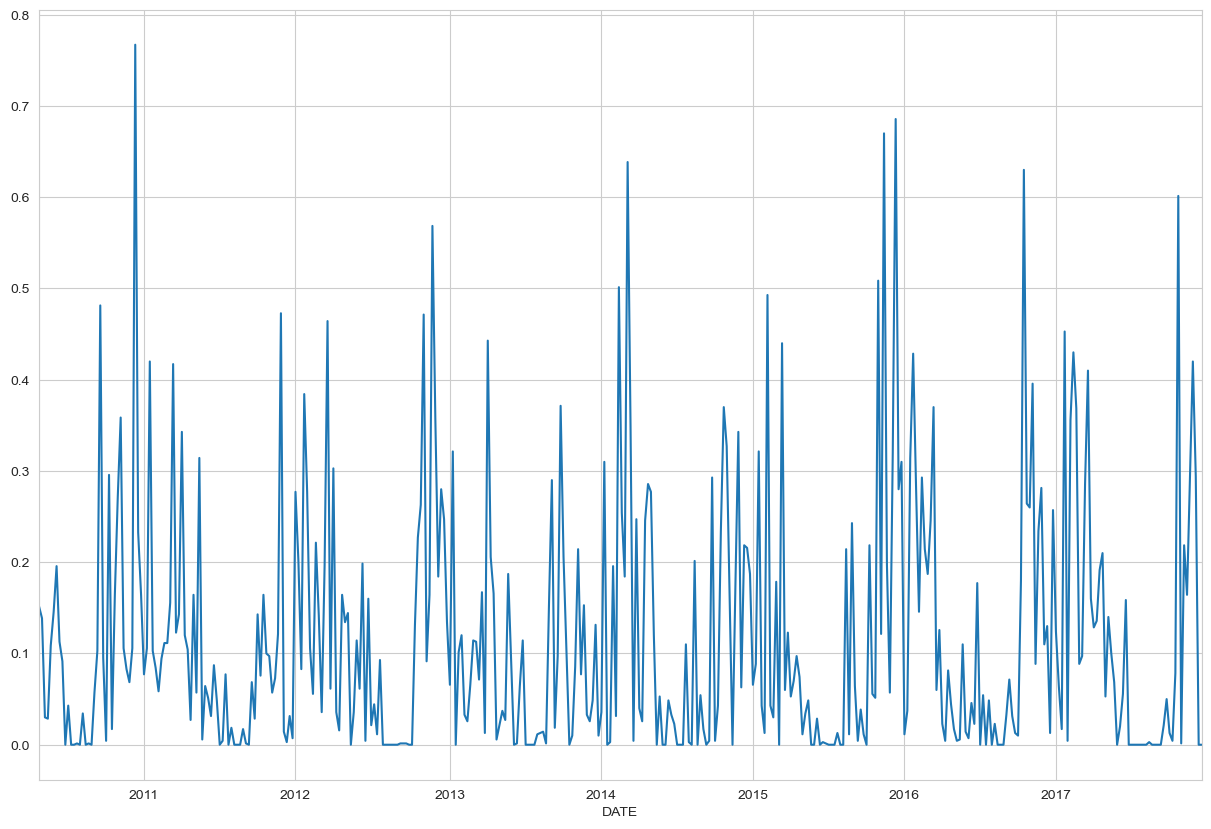

In [29]:
weather_weeks = weather_df.resample('W').mean()
weather_weeks['PRCP'].iloc[-400:].plot(subplots=True, figsize=(15, 10));

### 4.3 Декомпозиція часового ряду на компоненти

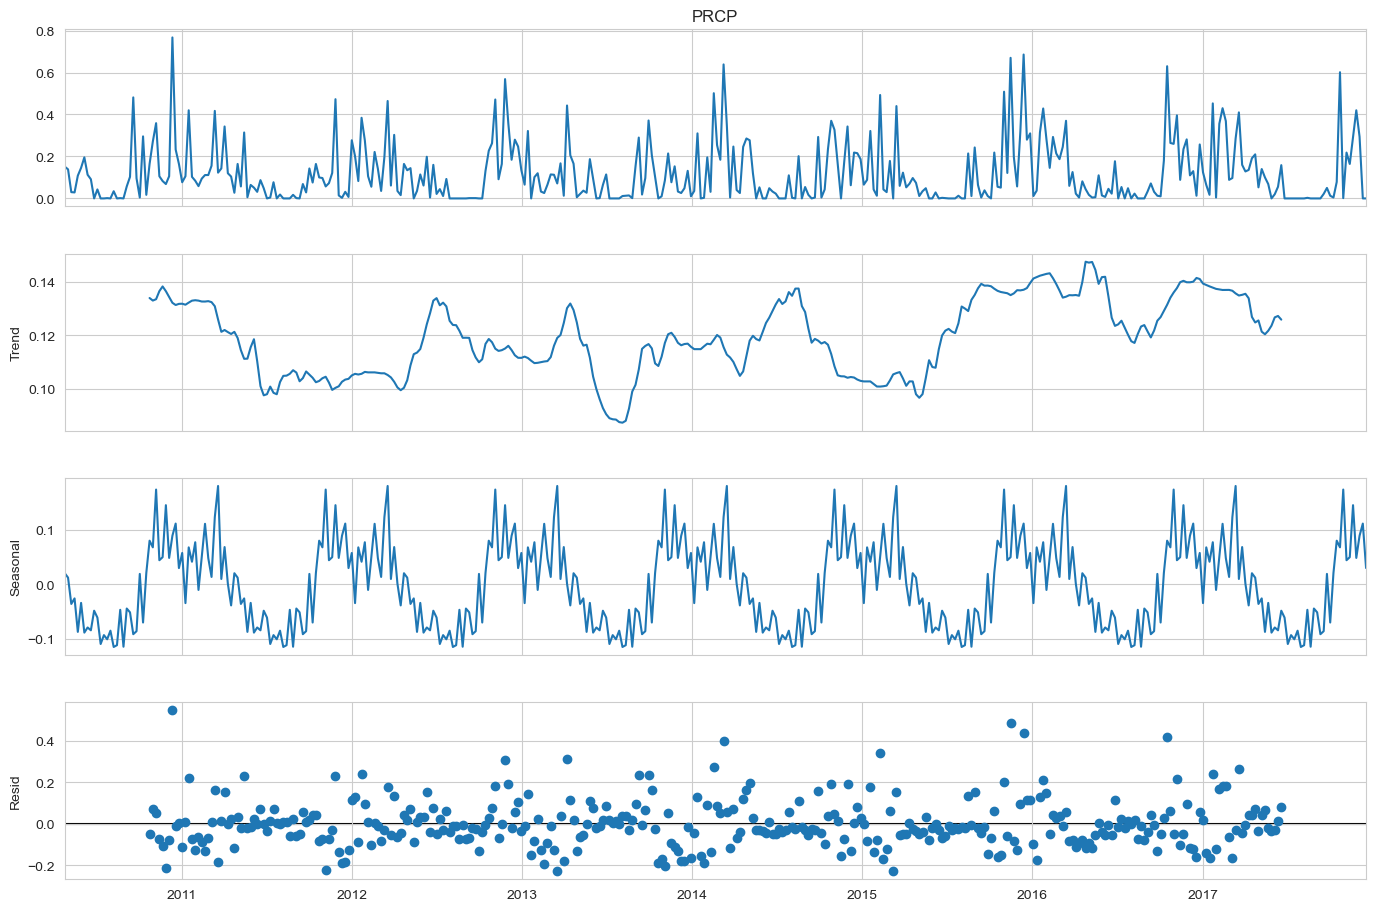

In [30]:
seasonal_decompose(weather_weeks.iloc[-400:]['PRCP']).plot().set_size_inches(15, 10)

### Візуалізація сезонної комопненти підвержує сезонність.

### 4.4 Графік корялеції та автокореляції

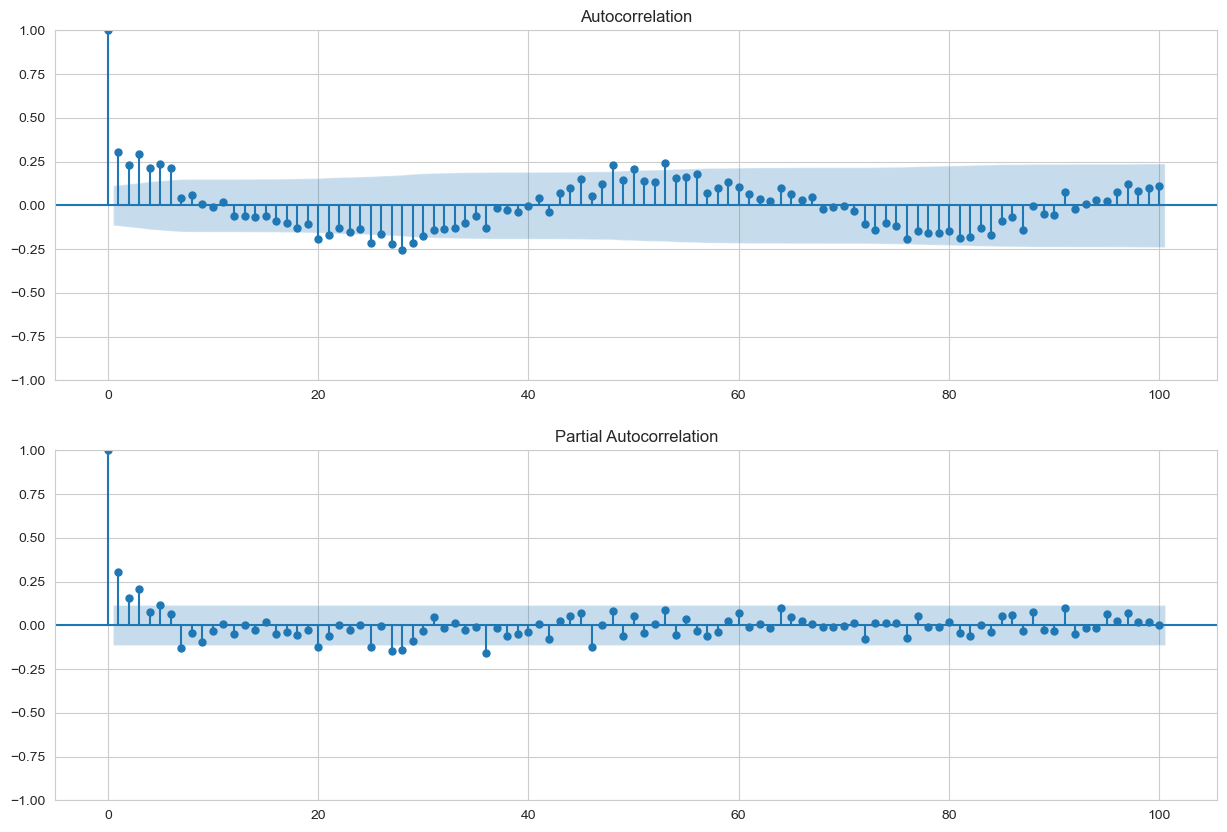

In [31]:
fig, ax = plt.subplots(2, figsize=(15, 10))
ax[0] = plot_acf(weather_weeks.iloc[-300:]['PRCP'], ax=ax[0], lags=100)
ax[1] = plot_pacf(weather_weeks.iloc[-300:]['PRCP'], ax=ax[1], lags=100, method='ywm')

### 4.5 Тест Дікі-Фуллера з метою перевірки часового ряду на стаціонарність

In [32]:
dickey_fuller_test(weather_weeks['PRCP'])

adf:  -18.581443438416628
p-value:  2.0777368929736715e-30
Critical values:  {'1%': -3.4321572194957715, '5%': -2.862338528678273, '10%': -2.567195069249532}
Одиничні корені відсутні, ряд є стаціонарним.


### 4.6 Створення навчальної вибірки (до 2010-го року) та підбір оптмальної моделі ARIMA

In [33]:
train_df = weather_df.loc[:'2010']
train_df = train_df.fillna(0)

In [34]:
model = auto_arima(train_df.iloc[-2000:]['PRCP'], start_p=0, start_q=0, max_p=3, max_q=3, seasonal=True, m=12,
                            start_P=0, d=None, D=1, trace=True, error_action='ignore', suppress_warnings=True,
                            stepwise=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=4.96 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1495.176, Time=0.14 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=694.943, Time=2.31 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=7.29 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1493.184, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1297.458, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=470.229, Time=146.40 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=239.62 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=13.05 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=687.516, Time=10.19 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=453.017, Time=4.85 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=676.571, Time=1.72 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=12.97 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=4.71 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=444.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 2000
Model:             SARIMAX(1, 0, 2)x(2, 1, [], 12)   Log Likelihood                -214.147
Date:                             Tue, 05 Sep 2023   AIC                            440.294
Time:                                     23:03:21   BIC                            473.864
Sample:                                 07-11-2005   HQIC                           452.624
                                      - 12-31-2010                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7471      0.051     14.561      0.000       0.647       0.848
ma.L1         -0.4650      0.052     -8.961      0.000      -0.567      -0.363
ma.L2         -0.0538      0.022     -2.394      0.017      -0.098      -0.010
ar.S.L12      -0.6920      0.012    -60.002      0.000      -0.715      -0.669
ar.S.L24      -0.3351      0.012    -26.990      0.000      -0.359      -0.311
sigma2         0.0724      0.001     92.740      0.000       0.071       0.074
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             52809.67
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             2.83
Prob(H) (two-sided):                  0.02   Kurtosis:                        27.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
model_sarimax = SARIMAX(train_df['PRCP'],
                                order=(1, 0, 2),
                                seasonal_order=(2, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_sarimax = model_sarimax.fit()

/Users/kyryl/miniforge3/envs/LabsDataAnalysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/kyryl/miniforge3/envs/LabsDataAnalysis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.98318D-02    |proj g|=  1.08360D+00


 This problem is unconstrained.



At iterate    5    f=  5.19454D-02    |proj g|=  4.16501D-03

At iterate   10    f=  5.19317D-02    |proj g|=  5.35657D-03

At iterate   15    f=  5.18293D-02    |proj g|=  2.05886D-02

At iterate   20    f=  5.17861D-02    |proj g|=  1.39026D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     28      1     0     0   3.514D-06   5.179D-02
  F =   5.1786120684816403E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


### 4.7 Прогноз кількості опадів на 2018 рік

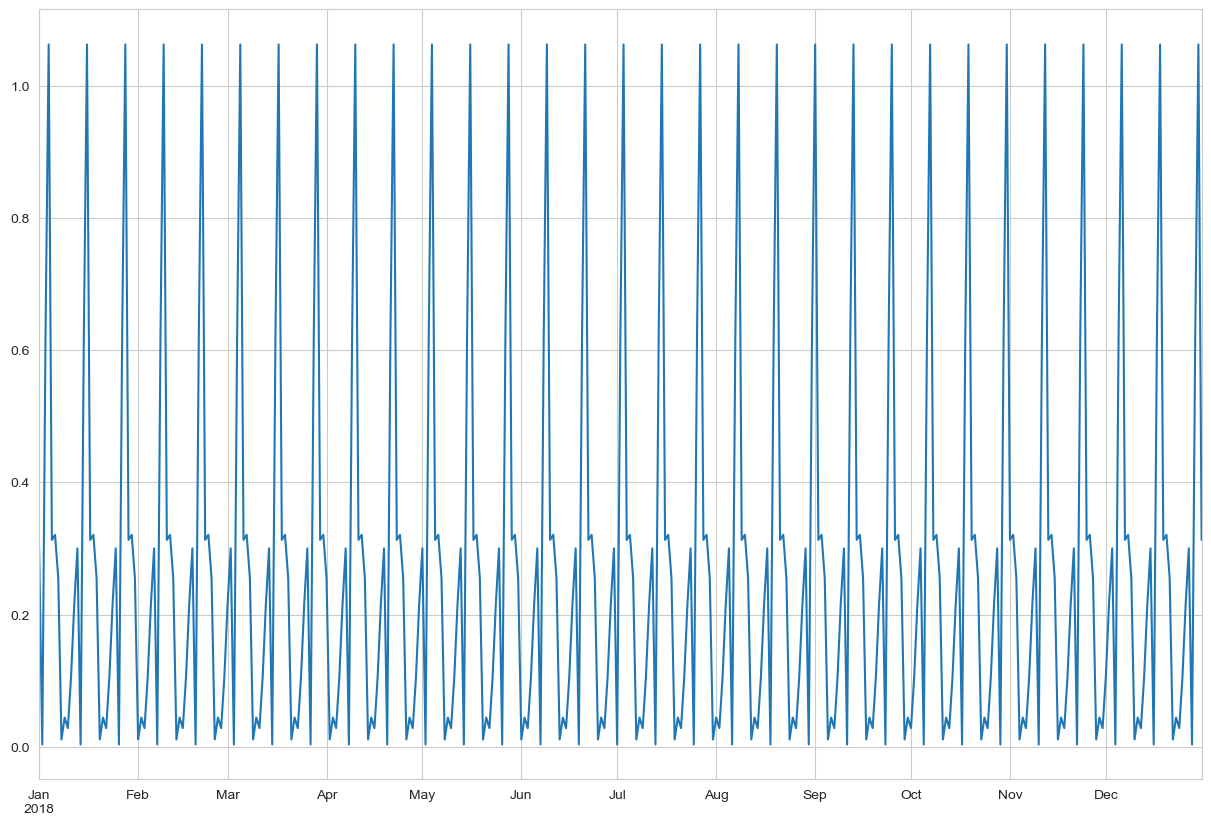

In [36]:
fig, ax = plt.subplots(figsize=(15, 10))
model_sarimax.forecast(steps=(pd.to_datetime('2018-12-31') - pd.to_datetime('2010-01-01')).days + 1).loc['2018-01-01':'2018-12-31'].plot(ax=ax);